# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Содержание:
* [Подготовка данных](#1-section)
* [Обучение моделе](#2-section)
* [Анализ моделей.](#3-section)
* [Выводы по проекту.](#4-section)

In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

## Подготовка данных<a id='1-section'></a>

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info

<bound method DataFrame.info of                 DateCrawled  Price  VehicleType  RegistrationYear Gearbox  \
0       2016-03-24 11:52:17    480          NaN              1993  manual   
1       2016-03-24 10:58:45  18300        coupe              2011  manual   
2       2016-03-14 12:52:21   9800          suv              2004    auto   
3       2016-03-17 16:54:04   1500        small              2001  manual   
4       2016-03-31 17:25:20   3600        small              2008  manual   
...                     ...    ...          ...               ...     ...   
354364  2016-03-21 09:50:58      0          NaN              2005  manual   
354365  2016-03-14 17:48:27   2200          NaN              2005     NaN   
354366  2016-03-05 19:56:21   1199  convertible              2000    auto   
354367  2016-03-19 18:57:12   9200          bus              1996  manual   
354368  2016-03-20 19:41:08   3400        wagon              2002  manual   

        Power        Model  Kilometer  Regi

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Проверим данные на наличие дубликатов.

In [5]:
df.duplicated().sum()

4

In [6]:
df = df.drop_duplicates()

Изучим аномалии в столбцах.

In [7]:
df['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Код регистрации не может быть позже даты последнего скачивания анкеты из базы.

In [8]:
last_date = pd.to_datetime(df['DateCrawled'])
last_date.max()

Timestamp('2016-04-07 14:36:58')

In [9]:
df = df.query('1910 < RegistrationYear < 2017')


<div class="alert alert-block alert-success">
<b>Успех:</b> С границами согласен
</div>


<AxesSubplot:>

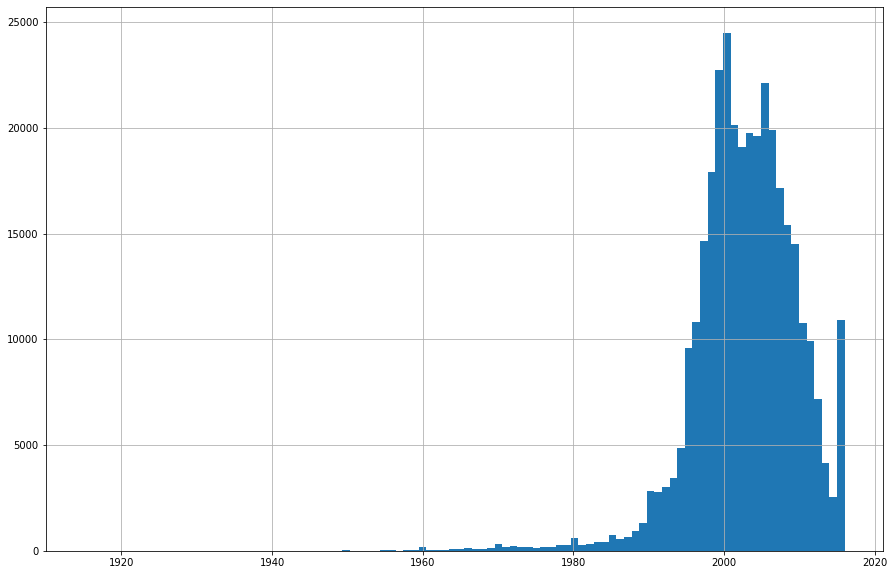

In [10]:
df['RegistrationYear'].hist(bins=100, figsize = (15,10))

Судя по графику сохраним значения значения года регистрации автомобиля с 1959 по 2017 год.

In [11]:
df = df.query('1959 < RegistrationYear < 2017')

Проверим столбуц можности двигателя (Power) на наличие аномалий. За максимальное значение возьмем 2028 л.с., так как это максимально возможное их количество.

In [12]:
df = df.query('Power < 2028')

<AxesSubplot:>

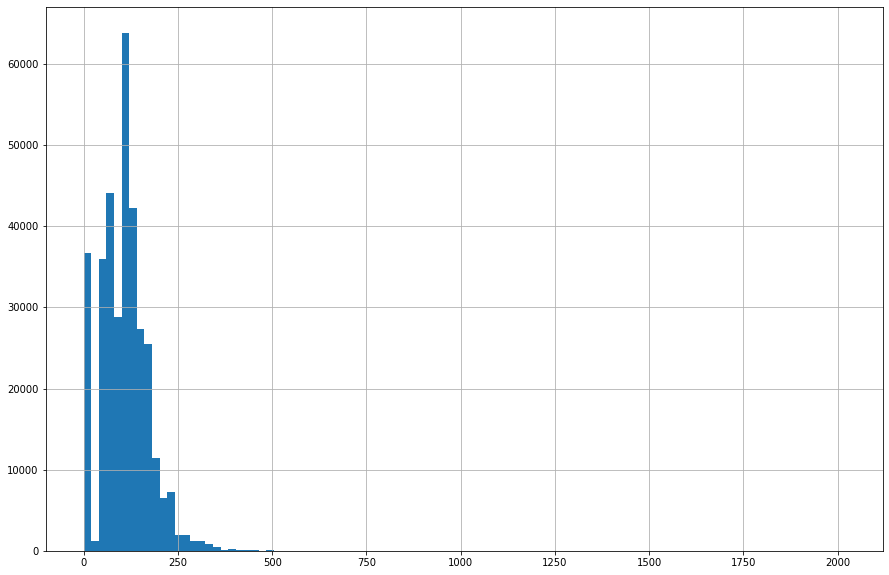

In [13]:
df['Power'].hist(bins=100, figsize = (15,10))

Судя по графику установим максиум в 500 л.с. Также на граффике присутствуют нулевые значения, избавимся от них.

In [14]:
df = df.query('0 < Power < 500')

Посмотрим на столбец цены.

<AxesSubplot:>

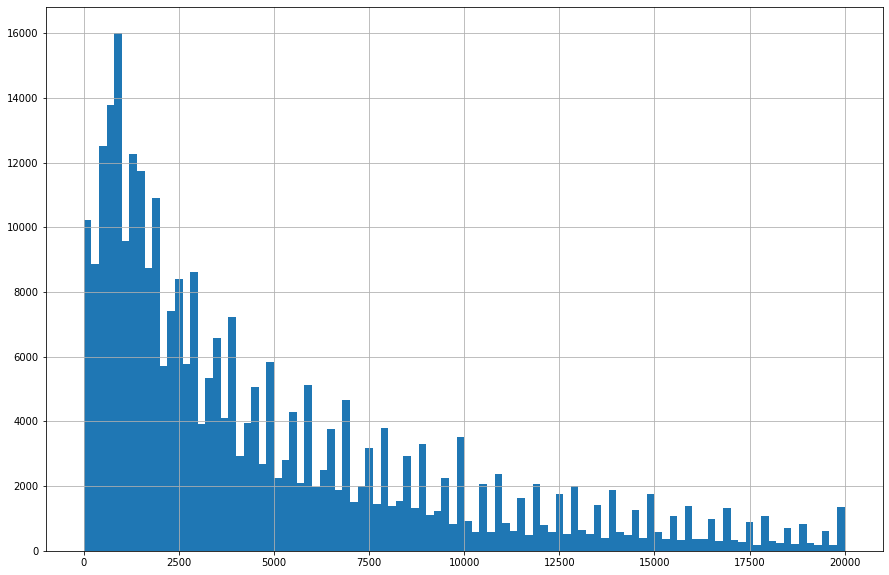

In [15]:
df['Price'].hist(bins=100, figsize = (15,10))

Так ка это целевой признак, то нулевые значения восстанавливать не будем.

In [16]:
df = df.query('0 < Price')

<div class="alert alert-block alert-success">
<b>Успех:</b>  А около-нулевые цены, не кажется подозрительными? Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div>

Некоторые столбцы не являются важными для нас, следовательно их можно удалить.

In [17]:
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures'])


<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - верное решение.
</div>

Проверим данные на пропуски

In [18]:
df.isna().sum()

Price                   0
VehicleType         11036
RegistrationYear        0
Gearbox              5370
Power                   0
Model               11139
Kilometer               0
FuelType            15551
Brand                   0
Repaired            42889
dtype: int64

Так как мы не знаем причину пропусков в столбцах VehicleType и Model, введем категорию "unknown" (неизвестно).

In [19]:
df['VehicleType'] = df['VehicleType'].fillna('un')

In [20]:
df['Model'] = df['Model'].fillna('un')

В столбце Repaired, пропуски скорее всего связаны с тем, что автомобиль не чинили. Поэтому переведем стобец в булевой тип, заменив yes (чинилась) на 1, no (не чинилась) на 0. 

In [21]:
df['Repaired'] = df['Repaired'].fillna('no')

In [22]:
df.loc[(df['Repaired'] != 'yes'), 'Repaired'] = 1

In [23]:
df.loc[(df['Repaired'] != 'no'), 'Repaired'] = 0

Заменим пропущенные значения стобцов типа топлива и коробки передач на моду, сгруппировав данные по марке и модели автомобиля. Данные в столбце Gearbox переведем в булев тип, заменив auto (автомат) на 1, manual (механика) на 0.

In [24]:
df['FuelType']= df.groupby(['Brand', 'Model'])['FuelType'].transform(lambda x: x.fillna((x.mode()[0])))

In [25]:
df['Gearbox']= df.groupby(['Brand', 'Model'])['Gearbox'].transform(lambda x: x.fillna((x.mode()[0])))

In [26]:
df['Gearbox'] = df['Gearbox'].map({'auto':1, 'manual':0}).astype(int)

In [27]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [28]:
df = df.astype({'Repaired': np.int})

/tmp/ipykernel_136/1046517715.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = df.astype({'Repaired': np.int})


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296319 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296319 non-null  int64 
 1   VehicleType       296319 non-null  object
 2   RegistrationYear  296319 non-null  int64 
 3   Gearbox           296319 non-null  int64 
 4   Power             296319 non-null  int64 
 5   Model             296319 non-null  object
 6   Kilometer         296319 non-null  int64 
 7   FuelType          296319 non-null  object
 8   Brand             296319 non-null  object
 9   Repaired          296319 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 24.9+ MB


In [30]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,0,190,un,125000,gasoline,audi,0
2,9800,suv,2004,1,163,grand,125000,gasoline,jeep,0
3,1500,small,2001,0,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,0,69,fabia,90000,gasoline,skoda,0
5,650,sedan,1995,0,102,3er,150000,petrol,bmw,0


**Вывод**

На данном этапе работы были изучены данные.

Избавились от дупликатов.

Обработали аномальные значения.

Обработали пропущенные значения.

## Обучение моделей <a id='2-section'></a>

В данной работе будем использовать следущие модели:
 - LinearRegression
 - DecisionTreeRegressor
 - CatBoost
 - LightGBM

Модели CatBoost и LightGBM работают с категориальными данными, только для модели LightGBM приведем категориальные признаки к формату category. Для остальных преобразуем признаки техникой One-Hot Encoding и стандартизируем их.

In [31]:
category = ['Brand','Model','VehicleType','FuelType']

In [32]:
target = df['Price']
features = df.drop('Price', axis=1)

In [33]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [34]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [35]:
target_ohe = df_ohe['Price']
features_ohe = df_ohe.drop('Price', axis=1)

In [36]:
features_ohe_tr, features_ohe_val, target_ohe_tr, target_ohe_valid = train_test_split(
    features_ohe, target_ohe, test_size=0.2, random_state=12345)
features_ohe_tr, features_ohe_test, target_ohe_tr, target_ohe_test = train_test_split(
    features_ohe_tr, target_ohe_tr, test_size=0.25, random_state=12345)

In [37]:
numeric = ['Power','Kilometer','RegistrationYear']

In [38]:
scaler = StandardScaler()
scaler.fit(features_ohe_tr[numeric])

StandardScaler()

In [39]:
features_ohe_tr[numeric] = scaler.transform(features_ohe_tr[numeric])
features_ohe_val[numeric] = scaler.transform(features_ohe_val[numeric]) 
features_ohe_test[numeric] = scaler.transform(features_ohe_test[numeric]) 

/tmp/ipykernel_136/3184776976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_ohe_val[numeric] = scaler.transform(features_ohe_val[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


**LinearRegression**

In [40]:
linear = LinearRegression()

In [41]:
%%time
linear.fit(features_ohe_tr, target_ohe_tr)

CPU times: user 8.36 s, sys: 3.75 s, total: 12.1 s
Wall time: 12.1 s


LinearRegression()

In [42]:
%%time
predictions_valid = linear.predict(features_ohe_val)
print('RMSE линейной модели:', mean_squared_error(target_ohe_valid, predictions_valid)**0.5)

RMSE линейной модели: 2604.5706888111476
CPU times: user 47.1 ms, sys: 70.8 ms, total: 118 ms
Wall time: 144 ms


**DecisionTReeRegressor**

In [43]:
tree = DecisionTreeRegressor(random_state=12345)

In [44]:
%%time
parameters = {'max_depth': range (1,10)}

clf = GridSearchCV(tree, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 5)

clf.fit(features_ohe_tr,target_ohe_tr)

print('Параметры:', clf.best_params_)

Параметры: {'max_depth': 9}
CPU times: user 50.4 s, sys: 5.81 s, total: 56.2 s
Wall time: 56.3 s


In [45]:
%%time
tree.fit(features_ohe_tr,target_ohe_tr)

CPU times: user 3.75 s, sys: 135 ms, total: 3.89 s
Wall time: 3.9 s


DecisionTreeRegressor(random_state=12345)

In [46]:
%%time

predictions_valid = tree.predict(features_ohe_val)
print('RMSE модели дерева решений:', mean_squared_error(target_ohe_valid, predictions_valid)**0.5)

RMSE модели дерева решений: 1888.7018692136696
CPU times: user 64.5 ms, sys: 39.9 ms, total: 104 ms
Wall time: 108 ms


In [47]:
%%time
predictions_valid = clf.predict(features_ohe_val)

print('RMSE модели дерева решений:', mean_squared_error(target_ohe_valid, predictions_valid)**0.5)

RMSE модели дерева решений: 2038.3266973650723
CPU times: user 32.3 ms, sys: 50.8 ms, total: 83.1 ms
Wall time: 90.7 ms


**CatBoostRegressor**

In [48]:
cat = CatBoostRegressor(random_state=12345)

In [49]:
%%time
cat.fit(features_train, target_train, cat_features = category, verbose = False)

CPU times: user 1min 59s, sys: 540 ms, total: 2min
Wall time: 2min 1s


In [50]:
%%time
predictions_valid = cat.predict(features_valid)
print('RMSE модели CatBoostRegression:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели CatBoostRegression: 1643.6948367922246
CPU times: user 330 ms, sys: 18 µs, total: 330 ms
Wall time: 331 ms


**LGBMRegressor**

In [51]:
lgmr = LGBMRegressor(random_state = 12345)

In [52]:
features_train[category] = features_train[category].astype('category')
features_valid[category] = features_valid[category].astype('category')
features_test[category] = features_test[category].astype('category')

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [53]:
%%time
lgmr.fit(features_train, target_train)

CPU times: user 3.98 s, sys: 12.6 ms, total: 3.99 s
Wall time: 3.97 s


LGBMRegressor(random_state=12345)

In [54]:
%%time
predictions_valid = lgmr.predict(features_valid)

print('RMSE модели LightGBM:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели LightGBM: 1662.9571430942838
CPU times: user 561 ms, sys: 0 ns, total: 561 ms
Wall time: 591 ms


**Вывод:**

На данном этапе были обучены и проверены на валидационной выборке следущие модели:LinearRegression, DecisionTreeRegressor, CatBoost, LightGBM.

Резултаты: 
 - LinearRegression RMSE=2604.6 , скорость обучения 53.1 s и со скоростью предсказания 342 ms.
 - DecisionTReeRegressor RMSE=1888.7 , скорость обучения 37.3 s и со скоростью предсказания 805 ms.
 - CatBoostRegressor RMSE=1643.7 , скорость обучения 3min 58s и со скоростью предсказания 766 ms.
 - LGBMRegressor RMSE=1663 со скоростью обучения 7min 12s и со скоростью предсказания 714 ms.

## Анализ моделей <a id='3-section'></a>

Проверим модели на тестовой выборке.

In [55]:
result = [["53.1 ms", "342 ms", 2604.4],
        ["37.3 s", "805 ms", 1888.7],
        ["3 min 58s", "766 ms", 1643.7],
        ["7 min 12s", "714 ms", 1663]]
model = ["Linear Regression", "DecisionTreeRegresso", "CatBoostRegressor", "LGBMRegressor"]

In [56]:
pd.DataFrame(data=result, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Linear Regression,53.1 ms,342 ms,2604.4
DecisionTreeRegresso,37.3 s,805 ms,1888.7
CatBoostRegressor,3 min 58s,766 ms,1643.7
LGBMRegressor,7 min 12s,714 ms,1663.0


Исходя из критериев заказчика наилучшей моделей будет DecisionTreeRegresso. У данной модели наилучшее качество, но время предсказания и скорости обучение выше.

In [57]:
%%time
predictions_test = tree.predict(features_ohe_test)
print('RMSE модели дерева решений:', mean_squared_error(target_ohe_test, predictions_test)**0.5)

RMSE модели дерева решений: 1915.543238858749
CPU times: user 69.3 ms, sys: 32.8 ms, total: 102 ms
Wall time: 101 ms


На тестовой выборке результаты незначительно отличаются от валидационной.

# Вывод по проекту <a id='4-section'></a>

Входе данного проета были изучены данные, обработаны анамальные значения, дубликаты и пропуски в данных.

Обучили и проверили следущие модели:LinearRegression, DecisionTreeRegressor, CatBoost, LightGBM.

In [58]:
pd.DataFrame(data=result, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Linear Regression,53.1 ms,342 ms,2604.4
DecisionTreeRegresso,37.3 s,805 ms,1888.7
CatBoostRegressor,3 min 58s,766 ms,1643.7
LGBMRegressor,7 min 12s,714 ms,1663.0


Входе анализа обученных моделей мы выяснили, что модели градиентного бустинга показали наилучший результат, чем модели дерева решения и линейной регрессии. Наиболее точной моделью оказалась CatBoostRegressor, следом за ней идет LGBMRegressor. Хотя скорость обучения и предсказания у моделей LinearRegression и DecisionTReeRegressor намного выше.

Исходя из требований заказчика наилучшей моделей была выбрана DecisionTReeRegressor со следущими показателями RMSE=1888.7 , скорость обучения 6.08 s и со скоростью предсказания 170 ms.

На тестовой выборке DecisionTReeRegressor показала следущие результаты: 

 - RMSE = 1915.5
 - Cкоростью предсказания 920 ms